## Notebook for plotting MixIRLS on reference files of ToF-ERDA experiments

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt

from utils.preprocess import load_tof, Phi
from utils.plot import make_palette
from image_processing import process

from models.mixture import MixIRLS

Load data, filter noise and feature engineer 

In [3]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X, y = load_tof(FILE_PATH, unique=True)
X, y = process(X,y, noise_sensitivity=0.9)

exponents = [-1/2] + [-1/i for i in range(3,10,2)]
phi = Phi(X, exponents)

Train model

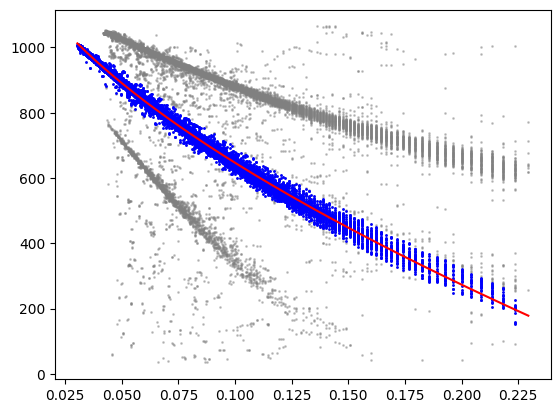

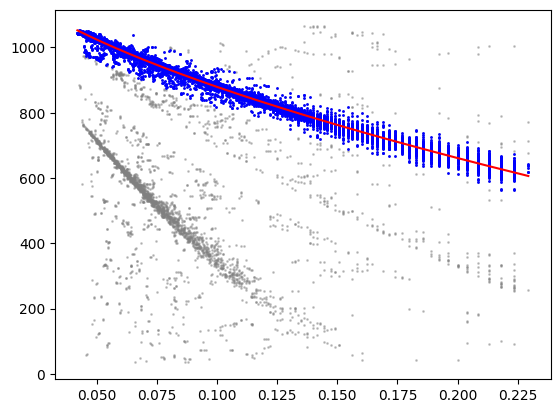

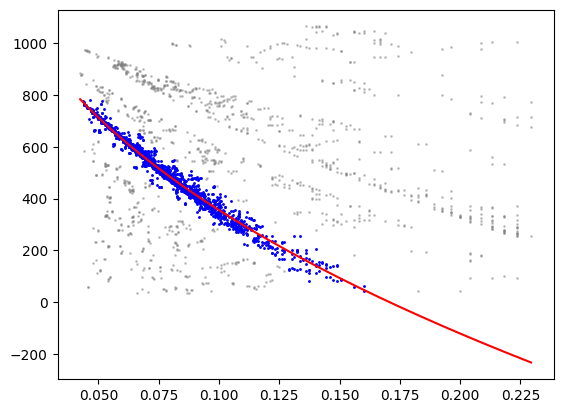

Parameters for 3 components:
 [[ 1.38142162e+03  1.33274122e+03  1.80536413e+03]
 [-5.23070045e-06 -7.70977482e-03 -3.19001937e-05]
 [-2.40329527e+03 -1.26360396e+03 -2.22615933e+02]
 [-5.44536019e+02 -4.54490476e+02 -3.52149744e+03]
 [-3.99031452e-01 -1.28386916e+00 -6.66178668e-01]
 [-9.50950866e-09 -2.04460129e-06 -1.01930841e-04]]


In [7]:
K = 3
w_th=0.95
alpha = 0.3
refinement_iter = 5
plot = True

model = MixIRLS(K=K, w_th=w_th, refinement_iter=refinement_iter, alpha=alpha, plot=plot)

sprim, supports, iter = model.train(phi, y)
print(f"Parameters for {K} components:\n", model.beta)

Plot results

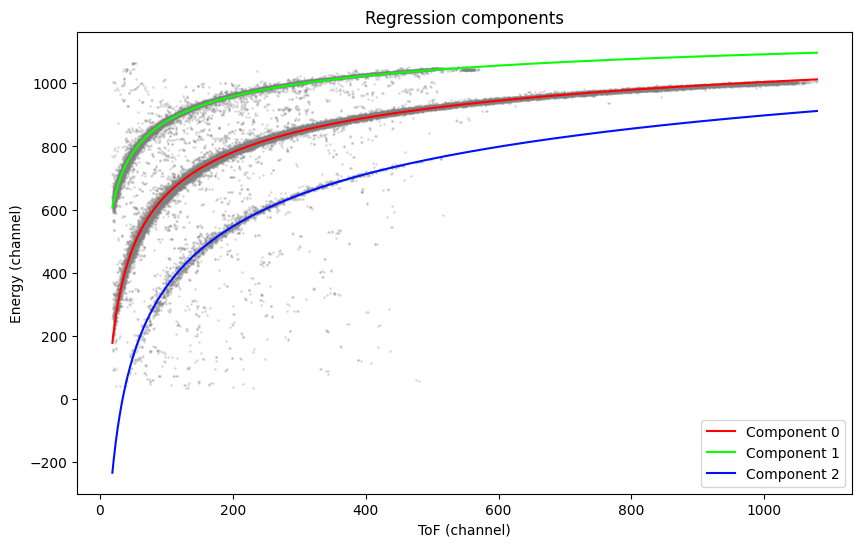

In [16]:
colors = make_palette(K+1, cmap=plt.cm.hsv)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Regression components')

# Predict all components at once
y_pred = model.predict(phi)

for k in range(K):
    plt.plot(X, y_pred[:,k], color=colors[k], label=f"Component {k}")
    
plt.legend()
plt.show()

Points in support for component 0:  28779
  Number of points in component 0:  17877

Points in support for component 1:  10902
  Number of points in component 1:  7867

Points in support for component 2:  3035
  Number of points in component 2:  1811



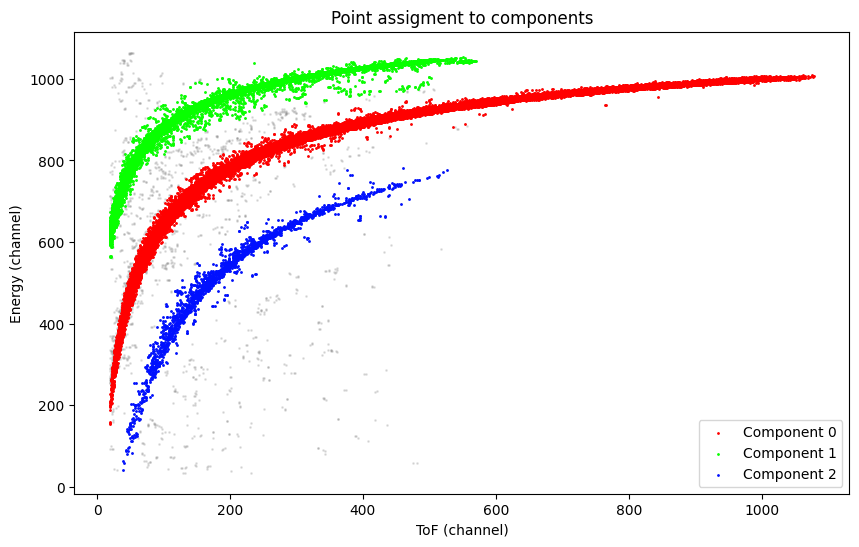

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, s=1, color='grey')
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Point assigment to components')
for k in range(K):
    
    i, j = model.get_component_indeces(k)
    E, ToF = model.get_component_points(X, y, k)

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]), end='\n\n')
    
    plt.scatter(E, ToF, alpha=1, s=1, marker='o',  color=colors[k], label=f"Component {k}")

plt.legend()
plt.show()